# Final Project - Basics of deep learning

## Part One - Transfer Learning

### Name and ID:
Student 1: Ofir Almog 207918731
<br>
Student 2: Adir Edri 206991762

## Import Libraries

In [ ]:
%%capture
!pip install ipython-autotime
%load_ext autotime

# --- File & System ---
import os
import shutil
import copy
import time
import json
import glob
import io
from collections import Counter
from PIL import Image

# --- Math & Data ---
import numpy as np
import pandas as pd
import scipy.io

# --- Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Torch & Vision ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

# --- External Data ---
import kagglehub
import gdown
from google.colab import drive, files

# --- Evaluation Metrics ---
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score
)

# --- Progress Display ---
from tqdm import tqdm

# --- KNN Classifier (if needed) ---
from sklearn.neighbors import KNeighborsClassifier

# --- Regex (for filename processing) ---
import re

time: 11 s (started: 2025-03-12 19:08:30 +00:00)


## Dataset
Cars196 - 196 different classes of vehicles

### Download Data

##### This block downloads the Stanford Cars dataset and its Excel mapping file. The dataset is organized into a designated folder, and the mapping file is read and processed for consistency between the training and test data.

In [ ]:
#Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")

100%|██████████| 1.82G/1.82G [01:02<00:00, 31.4MB/s]


time: 1min 17s (started: 2025-03-12 19:08:41 +00:00)


In [ ]:
#Create folders for dataset
!mkdir /content/dataset
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/* /content/dataset

time: 206 ms (started: 2025-03-12 19:09:58 +00:00)


In [ ]:
#download exel mapping file
file_id = "1FC1UietmwhfP4ROpwZfVbzzwCX8kRP85" #stanford cars exel file id
xls_path = "/content/cars_mapping.xlsx"
gdown.download(f"https://drive.google.com/uc?id={file_id}", xls_path, quiet=False) #sharing premissions enabled
df_mapping = pd.read_excel(xls_path)
df_test_mapping = pd.read_excel(xls_path, sheet_name="test")
df_test_mapping["image"] = df_test_mapping["image"].astype(str).str.replace("'", "").str.strip() #change image section in test sheet to match train sheet

Downloading...
From: https://drive.google.com/uc?id=1FC1UietmwhfP4ROpwZfVbzzwCX8kRP85
To: /content/cars_mapping.xlsx
100%|██████████| 798k/798k [00:00<00:00, 176MB/s]


time: 6.4 s (started: 2025-03-12 19:09:58 +00:00)


## Data Preproccesing

##### The dataset is processed by organizing the images into class-specific folders, applying necessary transformations, and preparing them for training by loading them into the DataLoader. These steps ensure the data is structured and formatted correctly for the model.


*   **get_class_and_model** - Retrieves the class number and model name for a given image.
*   **show_train_image_with_title** - Displays a training image with its class and model name as the title.
*    **organize_images** - Organizes images into class-specific folders based on the dataset mapping.
*   **Image Preprocessing** - Resizes, normalizes, and transforms the images for ResNet input, and loads them into DataLoader for batch processing.


In [ ]:
def get_class_and_model(image_name, df):
    """
    Returns the class number and model name for a given image from the provided DataFrame.

    Args:
        image_name (str): The image file name (e.g., "00163.jpg").
        df (DataFrame): DataFrame containing image, class, and true_class_name.

    Returns:
        tuple: (class_number, model_name) if found, else raises ValueError.
    """
    match = df[df["image"] == image_name]
    if not match.empty:
        return match["class"].values[0], match["true_class_name"].values[0]
    raise ValueError(f"Image {image_name} not found in mapping file.")


time: 488 µs (started: 2025-03-12 19:10:05 +00:00)


In [ ]:
def show_train_image_with_title(image_name, train_dataset_path, df_mapping):
    """
    Display a train image with its corrected class and model name as the title.
    """
    try:
        class_number, model_name = get_class_and_model(image_name, df_mapping)
        title = f"Class {class_number} → \"{model_name}\""
        image_path = os.path.join(train_dataset_path, image_name)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis("off")
        plt.title(title)
        plt.show()
    except ValueError as e:
        print(e)
    except FileNotFoundError:
        print(f"Train Image file not found: {image_path}")

time: 537 µs (started: 2025-03-12 19:10:05 +00:00)


In [ ]:
# Define dataset paths
train_dataset_path = "/content/dataset/cars_train/cars_train"
test_dataset_path = "/content/dataset/cars_test/cars_test"

# Organize images into class-named folders
def organize_images(df, dataset_path):
    for _, row in df.iterrows():
        image_name = row["image"]  # Assuming "image" is the correct column name
        class_name = str(row["ture_class_name"])

        class_folder = os.path.join(dataset_path, class_name)
        os.makedirs(class_folder, exist_ok=True)

        src, dst = os.path.join(dataset_path, image_name), os.path.join(class_folder, image_name)
        if os.path.exists(src):
            shutil.move(src, dst)  # Move image to its class folder

# Apply organization for both datasets
organize_images(df_mapping, train_dataset_path)
organize_images(df_test_mapping, test_dataset_path)


time: 1.59 s (started: 2025-03-12 19:10:05 +00:00)


In [ ]:
# Image preprocessing for ResNet input
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # Standard ResNet normalization
])

# Load datasets and apply transformations
train_dataset = ImageFolder(root=train_dataset_path, transform=transform)
test_dataset = ImageFolder(root=test_dataset_path, transform=transform)

# Wrap datasets in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Display dataset info
print(f"Train Dataset Size: {len(train_dataset)} images")
print(f"Test Dataset Size: {len(test_dataset)} images")
print(f"Number of Classes: {len(train_dataset.classes)}")


Train Dataset Size: 8144 images
Test Dataset Size: 8041 images
Number of Classes: 196
time: 43.8 ms (started: 2025-03-12 19:10:06 +00:00)


### Generic train and validation functions

##### This section includes functions for training, evaluating, and visualizing the model's performance. It trains the model, evaluates it on a test set, and plots the training history.



*   **train_model** - Trains the model with validation at each epoch and returns the best model and history.
*   **evaluate_model** - Evaluates the model on the test set and computes accuracy, F1 score, precision, and recall.
*   **plot_training_history** - Plots the training and validation accuracy and loss.
*   **compare_experiments** - Compares metrics from multiple experiments and outputs a DataFrame.



In [ ]:
# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device: cuda:0
time: 48.1 ms (started: 2025-03-12 19:10:06 +00:00)


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10, device=None):
    """
    Generic function to train a model with validation at each epoch.

    Args:
        model: PyTorch model to train
        dataloaders: Dictionary containing 'train' and 'val' dataloaders
        criterion: Loss function
        optimizer: Optimizer for training
        scheduler: Learning rate scheduler
        num_epochs: Number of epochs to train for
        device: Device to train on (defaults to cuda if available, else cpu)

    Returns:
        model: Trained model (best validation accuracy)
        history: Training history dictionary
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    # Initialize history dictionary to track metrics
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'time_per_epoch': []
    }

    # Keep track of best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Training loop per epoch
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}\n{"-" * 10}')
        epoch_start_time = time.time()

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0
            pbar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()}")

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix(loss=loss.item())

            if phase == 'train' and scheduler:  # Call scheduler.step() only once after the training phase
                scheduler.step()  # Removed duplicate scheduler.step() call

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # Deep copy the model if it's the best validation accuracy so far
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        # Calculate time per epoch
        epoch_time = time.time() - epoch_start_time
        history['time_per_epoch'].append(epoch_time)

        print(f'Epoch complete in {epoch_time:.0f}s')
        print()

    # Calculate total time
    total_time = sum(history['time_per_epoch'])
    print(f'Training complete in {total_time//60:.0f}m {total_time%60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


def evaluate_model(model, dataloader, criterion, device=None):
    """
    Evaluate a model on a test set

    Args:
        model: Trained PyTorch model
        dataloader: DataLoader for test data
        criterion: Loss function
        device: Device to evaluate on

    Returns:
        metrics: Dictionary containing evaluation metrics
        all_labels: All true labels
        all_preds: All predicted labels
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            # Convert to CPU numpy for sklearn metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate total loss
    total_loss = running_loss / len(dataloader.dataset)

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

    metrics = {
        'loss': total_loss,
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds, average='weighted'),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted')
    }

    return metrics, all_labels, all_preds


def plot_training_history(history, title="Model Training History"):
    """
    Plot training and validation accuracy/loss

    Args:
        history: History dictionary from train_model
        title: Plot title
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def compare_experiments(metrics_list, experiment_names):
    """
    Compare metrics from multiple experiments

    Args:
        metrics_list: List of metrics dictionaries from evaluate_model
        experiment_names: List of experiment names

    Returns:
        df: DataFrame with comparison
    """
    import pandas as pd

    # Create DataFrame
    df = pd.DataFrame(index=experiment_names)

    # Add metrics for each experiment
    for i, metrics in enumerate(metrics_list):
        for metric, value in metrics.items():
            df.loc[experiment_names[i], metric] = value

    return df

time: 3.87 ms (started: 2025-03-12 19:10:07 +00:00)


### Model Setup and Parameter Initialization
##### This block initializes a pre-trained model (such as ResNet50 or DenseNet121) for fine-tuning based on the given parameters. It also includes a helper function to freeze parameters for feature extraction.



In [ ]:
def setup_model(model_name, num_classes, feature_extract=True):
    """
    Initialize a pre-trained model for fine-tuning.
    """
    model = None
    input_size = 224  # All models use 224x224 input size

    if model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model, feature_extract)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model, feature_extract)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model, feature_extract)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    elif model_name == "densenet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model, feature_extract)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model, feature_extract)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    else:
        print(f"Invalid model name: {model_name}. Using ResNet18 as default.")
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model, feature_extract)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

def set_parameter_requires_grad(model, feature_extract):
    """
    Disable gradients for all parameters if feature_extract=True
    """
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

time: 825 µs (started: 2025-03-12 19:10:07 +00:00)



### Experiment Tracker Class
##### The ExperimentTracker class helps track and save multiple experiments. It allows saving metrics, histories, and models, as well as comparing and plotting metrics across experiments for easy analysis.



In [ ]:
class ExperimentTracker:
    """
    Class to track and compare multiple experiments
    """
    def __init__(self, save_dir="experiment_results"):
        self.experiments = {}
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def add_experiment(self, name, model, metrics, history):
        self.experiments[name] = {
            "model": model,
            "metrics": metrics,
            "history": history
        }
        self._save_experiment(name, metrics, history)

    def _save_experiment(self, name, metrics, history):
        exp_dir = os.path.join(self.save_dir, name)
        os.makedirs(exp_dir, exist_ok=True)

        # Save metrics
        with open(os.path.join(exp_dir, "metrics.json"), 'w') as f:
            json.dump(metrics, f, indent=4)

        # Prepare history for JSON
        history_serializable = {
            k: [float(x) for x in v] if isinstance(v, list) and v and (isinstance(v[0], np.ndarray) or torch.is_tensor(v[0])) else v
            for k, v in history.items()
        }

        # Save history
        with open(os.path.join(exp_dir, "history.json"), 'w') as f:
            json.dump(history_serializable, f, indent=4)

    def compare_metrics(self, metric_names=None):
        if not self.experiments:
            print("No experiments to compare.")
            return None

        if metric_names is None:
            first_exp = next(iter(self.experiments.values()))
            metric_names = list(first_exp["metrics"].keys())

        comparison = {
            metric: {
                name: exp["metrics"][metric]
                for name, exp in self.experiments.items()
                if metric in exp["metrics"]
            }
            for metric in metric_names
        }

        return pd.DataFrame(comparison)

    def plot_metric_comparison(self, metric="accuracy"):
        if not self.experiments:
            print("No experiments to compare.")
            return

        names, values = [], []
        for name, exp in self.experiments.items():
            if metric in exp["metrics"]:
                names.append(name)
                values.append(exp["metrics"][metric])

        if not values:
            print(f"No data found for metric: {metric}")
            return

        plt.figure(figsize=(10, 6))
        bars = plt.bar(names, values)

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom')

        plt.title(f'Comparison of {metric.capitalize()} Across Experiments')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Experiment')
        plt.ylim(0, 1.0 if max(values) < 1.0 else max(values) * 1.1)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_history_comparison(self, metric="val_acc"):
        if not self.experiments:
            print("No experiments to compare.")
            return

        plt.figure(figsize=(12, 6))
        for name, exp in self.experiments.items():
            if metric in exp["history"]:
                plt.plot(exp["history"][metric], label=name)

        plt.title(f'Comparison of {metric} Across Experiments')
        plt.ylabel(metric.replace('_', ' ').capitalize())
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def find_best_experiment(self, metric="accuracy"):
        if not self.experiments:
            print("No experiments to compare.")
            return None, None

        best_name, best_value = None, -float('inf')
        for name, exp in self.experiments.items():
            value = exp["metrics"].get(metric)
            if value is not None and value > best_value:
                best_value = value
                best_name = name

        if best_name is None:
            print(f"No data found for metric: {metric}")
            return None, None

        print(f"Best experiment based on {metric}: {best_name} with value {best_value:.4f}")
        return best_name, best_value

    def save_best_model(self, metric="accuracy", save_path=None):
        best_name, _ = self.find_best_experiment(metric)
        if best_name is None:
            return None

        model = self.experiments[best_name]["model"]
        save_path = save_path or f"best_model_{metric}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Best model ({best_name}) saved to {save_path}")
        return best_name


# Dataset sizes
train_dataset_size = len(train_dataset)
test_dataset_size = len(test_dataset)
print(f"Original train dataset size: {train_dataset_size}")
print(f"Original test dataset size: {test_dataset_size}")

# Split test dataset into validation and test
test_to_val_size = int(2/3 * test_dataset_size)
test_indices = list(range(test_dataset_size))
torch.manual_seed(42)
test_indices_shuffled = test_indices.copy()
np.random.shuffle(test_indices_shuffled)

val_indices = test_indices_shuffled[:test_to_val_size]
new_test_indices = test_indices_shuffled[test_to_val_size:]

val_subset = Subset(test_dataset, val_indices)
new_test_subset = Subset(test_dataset, new_test_indices)
train_subset = train_dataset  # unchanged

# Create loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(new_test_subset, batch_size=32, shuffle=False, num_workers=4)

# Update global dataloaders
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

# Initialize experiment tracker
experiment_tracker = ExperimentTracker(save_dir="experiment_results")


Original train dataset size: 8144
Original test dataset size: 8041
time: 6.7 ms (started: 2025-03-12 19:10:07 +00:00)



### Experiment 1-1: ResNet50 with Feature Extraction
##### In this experiment, ResNet50 is trained using only its classifier layer with feature extraction enabled. Basic data augmentation is applied, and the model is evaluated on the test set. The experiment's results, including the model's performance, are saved for further analysis.




EXPERIMENT 1-1: ResNet50 with Feature Extraction


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]



Trainable: 401,604 / 23,909,636 (1.68%)

Hyperparameters:
- LR: 0.001 | Batch Size: 32 | Epochs: 10
- Optimizer: Adam | Loss: CrossEntropy | Scheduler: StepLR

Starting training...
Epoch 1/10
----------


Train: 100%|██████████| 255/255 [00:28<00:00,  9.03it/s, loss=4.6]


Train Loss: 4.8396 Acc: 0.0760


Val: 100%|██████████| 168/168 [00:17<00:00,  9.72it/s, loss=3.79]


Val Loss: 3.8826 Acc: 0.1903
Epoch complete in 46s

Epoch 2/10
----------


Train: 100%|██████████| 255/255 [00:28<00:00,  8.90it/s, loss=3.47]


Train Loss: 3.2448 Acc: 0.2832


Val: 100%|██████████| 168/168 [00:17<00:00,  9.71it/s, loss=3.68]


Val Loss: 3.4080 Acc: 0.2371
Epoch complete in 46s

Epoch 3/10
----------


Train: 100%|██████████| 255/255 [00:27<00:00,  9.32it/s, loss=2.28]


Train Loss: 2.5394 Acc: 0.4207


Val: 100%|██████████| 168/168 [00:17<00:00,  9.74it/s, loss=2.38]


Val Loss: 3.0366 Acc: 0.3024
Epoch complete in 45s

Epoch 4/10
----------


Train: 100%|██████████| 255/255 [00:27<00:00,  9.12it/s, loss=1.92]


Train Loss: 2.0988 Acc: 0.5066


Val: 100%|██████████| 168/168 [00:17<00:00,  9.75it/s, loss=3.1]


Val Loss: 2.8987 Acc: 0.3282
Epoch complete in 45s

Epoch 5/10
----------


Train: 100%|██████████| 255/255 [00:27<00:00,  9.25it/s, loss=1.7]


Train Loss: 1.8022 Acc: 0.5684


Val: 100%|██████████| 168/168 [00:17<00:00,  9.69it/s, loss=2.51]


Val Loss: 2.8851 Acc: 0.3248
Epoch complete in 45s

Epoch 6/10
----------


Train: 100%|██████████| 255/255 [00:27<00:00,  9.16it/s, loss=1.31]


Train Loss: 1.5839 Acc: 0.6138


Val: 100%|██████████| 168/168 [00:17<00:00,  9.68it/s, loss=2.33]


Val Loss: 2.7166 Acc: 0.3522
Epoch complete in 45s

Epoch 7/10
----------


Train: 100%|██████████| 255/255 [00:27<00:00,  9.23it/s, loss=2.36]


Train Loss: 1.3854 Acc: 0.6655


Val: 100%|██████████| 168/168 [00:17<00:00,  9.69it/s, loss=2.81]


Val Loss: 2.6860 Acc: 0.3588
Epoch complete in 45s

Epoch 8/10
----------


Train: 100%|██████████| 255/255 [00:27<00:00,  9.19it/s, loss=1.05]


Train Loss: 0.9546 Acc: 0.8226


Val: 100%|██████████| 168/168 [00:17<00:00,  9.67it/s, loss=2.09]


Val Loss: 2.3685 Acc: 0.4261
Epoch complete in 45s

Epoch 9/10
----------


Train: 100%|██████████| 255/255 [00:28<00:00,  9.07it/s, loss=1.19]


Train Loss: 0.9112 Acc: 0.8438


Val: 100%|██████████| 168/168 [00:17<00:00,  9.67it/s, loss=1.97]


Val Loss: 2.3869 Acc: 0.4203
Epoch complete in 46s

Epoch 10/10
----------


Train: 100%|██████████| 255/255 [00:27<00:00,  9.12it/s, loss=0.792]


Train Loss: 0.9067 Acc: 0.8428


Val: 100%|██████████| 168/168 [00:17<00:00,  9.68it/s, loss=2.03]


Val Loss: 2.3744 Acc: 0.4256
Epoch complete in 45s

Training complete in 7m 33s
Best val Acc: 0.4261


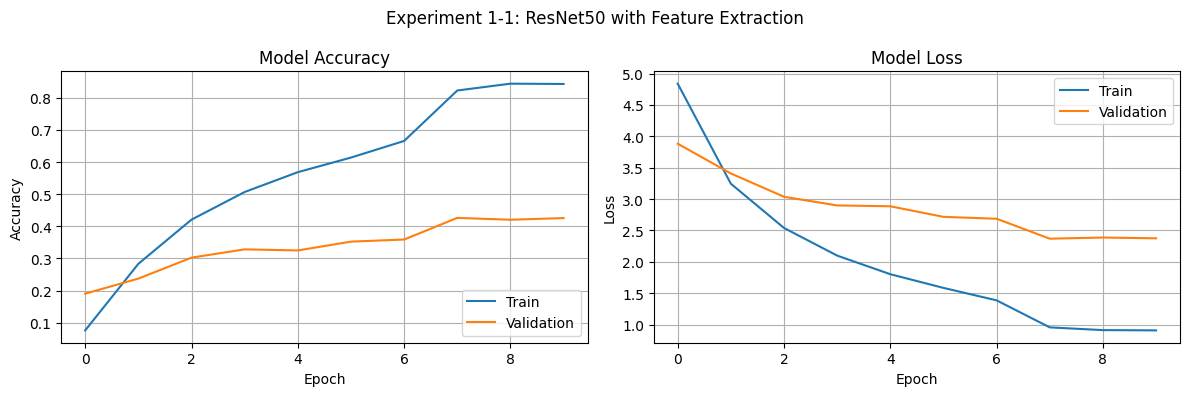


Evaluating on test set...


Evaluating: 100%|██████████| 252/252 [00:25<00:00,  9.92it/s]


Loss: 2.3724
F1: 0.4196
Recall: 0.4237
Precision: 0.4291
Accuracy: 0.4237
Model saved to resnet50_feature_extraction.pth
time: 8min (started: 2025-03-12 19:10:07 +00:00)


In [ ]:
def experiment1_1_resnet50_feature_extraction(train_subset, val_subset, test_dataset, batch_size=32, num_epochs=10, device=device):
    """
    Experiment 1-1: ResNet50 with Feature Extraction
    - Only trains the classifier (final layer)
    - Basic augmentation: RandomResizedCrop, HorizontalFlip
    """
    print("\n" + "="*70)
    print("EXPERIMENT 1-1: ResNet50 with Feature Extraction")
    print("="*70)

    # Basic augmentation (for reference, not applied directly to dataset here)
    basic_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    dataloaders = {'train': train_loader, 'val': val_loader}

    # Number of classes
    num_classes = len(train_dataset.classes)

    # Model setup
    model = setup_model('resnet50', num_classes, feature_extract=True)

    # Print model parameter info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTrainable: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.2f}%)")

    # Hyperparameters summary
    print("\nHyperparameters:")
    print(f"- LR: 0.001 | Batch Size: {batch_size} | Epochs: {num_epochs}")
    print("- Optimizer: Adam | Loss: CrossEntropy | Scheduler: StepLR")

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train
    print("\nStarting training...")
    model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, device)

    # Plot training history
    plot_training_history(history, title="Experiment 1-1: ResNet50 with Feature Extraction")

    # Evaluate
    print("\nEvaluating on test set...")
    metrics, labels, preds = evaluate_model(model, test_loader, criterion, device)

    for key in ['loss', 'f1', 'recall', 'precision', 'accuracy']:
        print(f"{key.capitalize()}: {metrics[key]:.4f}")

    # Save model
    save_path = "resnet50_feature_extraction.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics,
        'history': history,
        'num_classes': num_classes,
        'epoch': num_epochs
    }, save_path)
    print(f"Model saved to {save_path}")

    return model, metrics, history


# Run and track
model_1_1, metrics_1_1, history_1_1 = experiment1_1_resnet50_feature_extraction(
    train_subset, val_subset, test_dataset, num_epochs=10
)

experiment_tracker.add_experiment("ResNet50_FeatureExtraction", model_1_1, metrics_1_1, history_1_1)



### Experiment 1-2: ResNet50 Fine-Tuning
##### This experiment fine-tunes all layers of ResNet50 in two stages, applying advanced augmentation techniques. The first stage trains only the classifier, while the second stage unfreezes all layers for fine-tuning. The model's performance is evaluated and saved.




EXPERIMENT 1-2: ResNet50 with Fine-Tuning

=== STAGE 1: Training only classifier ===
Trainable: 401,604 / 23,909,636 (1.68%)
Epoch 1/5
----------


Train: 100%|██████████| 255/255 [00:33<00:00,  7.63it/s, loss=5.01]


Train Loss: 5.3889 Acc: 0.0287


Val: 100%|██████████| 168/168 [00:17<00:00,  9.64it/s, loss=4.52]


Val Loss: 4.7538 Acc: 0.0744
Epoch complete in 51s

Epoch 2/5
----------


Train: 100%|██████████| 255/255 [00:32<00:00,  7.74it/s, loss=5.19]


Train Loss: 4.6567 Acc: 0.0828


Val: 100%|██████████| 168/168 [00:17<00:00,  9.59it/s, loss=3.62]


Val Loss: 4.2819 Acc: 0.1123
Epoch complete in 50s

Epoch 3/5
----------


Train: 100%|██████████| 255/255 [00:33<00:00,  7.72it/s, loss=4.11]


Train Loss: 4.2801 Acc: 0.1315


Val: 100%|██████████| 168/168 [00:17<00:00,  9.69it/s, loss=3.48]


Val Loss: 3.8982 Acc: 0.1567
Epoch complete in 50s

Epoch 4/5
----------


Train: 100%|██████████| 255/255 [00:33<00:00,  7.64it/s, loss=4.42]


Train Loss: 4.0614 Acc: 0.1566


Val: 100%|██████████| 168/168 [00:17<00:00,  9.67it/s, loss=3.35]


Val Loss: 3.7727 Acc: 0.1621
Epoch complete in 51s

Epoch 5/5
----------


Train: 100%|██████████| 255/255 [00:32<00:00,  7.76it/s, loss=4.39]


Train Loss: 3.9243 Acc: 0.1714


Val: 100%|██████████| 168/168 [00:17<00:00,  9.65it/s, loss=3.12]


Val Loss: 3.7568 Acc: 0.1808
Epoch complete in 50s

Training complete in 4m 13s
Best val Acc: 0.1808

=== STAGE 2: Fine-tuning all layers ===
Trainable (Stage 2): 23,909,636 / 23,909,636 (100.00%)
Epoch 1/5
----------


Train: 100%|██████████| 255/255 [01:40<00:00,  2.53it/s, loss=1.67]


Train Loss: 2.6170 Acc: 0.3885


Val: 100%|██████████| 168/168 [00:17<00:00,  9.64it/s, loss=1.47]


Val Loss: 1.6011 Acc: 0.5701
Epoch complete in 118s

Epoch 2/5
----------


Train: 100%|██████████| 255/255 [01:40<00:00,  2.54it/s, loss=1.49]


Train Loss: 1.8106 Acc: 0.5696


Val: 100%|██████████| 168/168 [00:17<00:00,  9.68it/s, loss=1.33]


Val Loss: 1.2231 Acc: 0.6593
Epoch complete in 118s

Epoch 3/5
----------


Train: 100%|██████████| 255/255 [01:40<00:00,  2.54it/s, loss=2.06]


Train Loss: 1.5080 Acc: 0.6372


Val: 100%|██████████| 168/168 [00:17<00:00,  9.69it/s, loss=1.15]


Val Loss: 1.1102 Acc: 0.6935
Epoch complete in 118s

Epoch 4/5
----------


Train: 100%|██████████| 255/255 [01:40<00:00,  2.54it/s, loss=2.99]


Train Loss: 1.3123 Acc: 0.6821


Val: 100%|██████████| 168/168 [00:17<00:00,  9.62it/s, loss=1.08]


Val Loss: 0.9675 Acc: 0.7241
Epoch complete in 118s

Epoch 5/5
----------


Train: 100%|██████████| 255/255 [01:40<00:00,  2.54it/s, loss=1.31]


Train Loss: 1.1722 Acc: 0.7048


Val: 100%|██████████| 168/168 [00:17<00:00,  9.64it/s, loss=1]


Val Loss: 0.8705 Acc: 0.7554
Epoch complete in 118s

Training complete in 9m 49s
Best val Acc: 0.7554


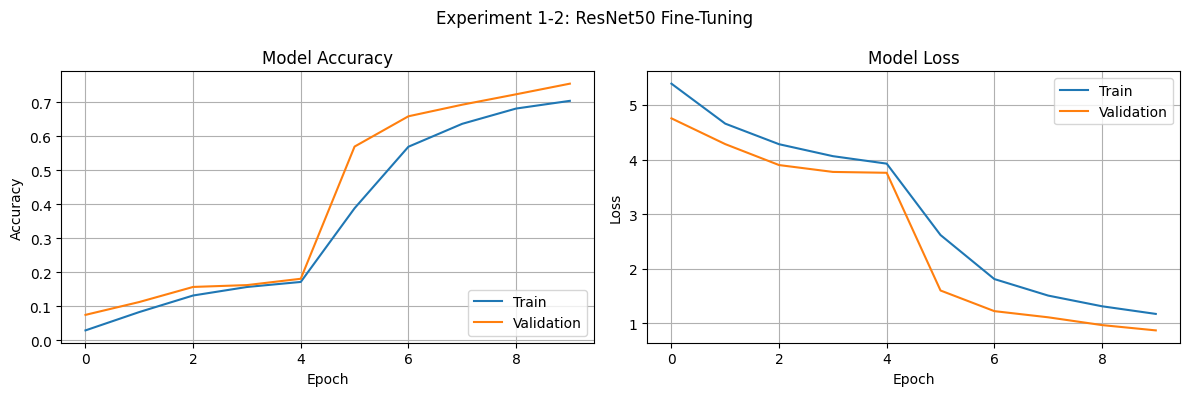


Evaluating model...


Evaluating: 100%|██████████| 84/84 [00:08<00:00,  9.55it/s]


Loss: 0.9012
F1: 0.7363
Recall: 0.7378
Precision: 0.7818
Accuracy: 0.7378
Model saved to resnet50_finetune.pth
time: 16min 13s (started: 2025-03-12 19:18:07 +00:00)


In [ ]:
def experiment1_2_resnet50_finetune(train_subset, val_subset, test_subset, batch_size=32, num_epochs=10, device=device):
    """
    Experiment 1-2: ResNet50 Fine-Tuning (2 stages with advanced augmentation)
    """
    print("\n" + "="*70)
    print("EXPERIMENT 1-2: ResNet50 with Fine-Tuning")
    print("="*70)

    # Advanced augmentation
    advanced_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2)
    ])

    # Detect root directory if possible
    train_root_dir = getattr(train_subset, 'root', None)
    if not train_root_dir and hasattr(train_subset, 'dataset'):
        train_root_dir = getattr(train_subset.dataset, 'root', None)

    if train_root_dir:
        train_dataset_aug = ImageFolder(root=train_root_dir, transform=advanced_transform)
        train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True, num_workers=4)
    else:
        print("Warning: Couldn't apply advanced augmentation. Using existing subset.")
        train_loader_aug = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)

    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4)

    dataloaders_stage1 = {'train': train_loader_aug, 'val': val_loader}
    num_classes = len(train_dataset.classes)

    # === Stage 1 ===
    print("\n=== STAGE 1: Training only classifier ===")
    model = setup_model('resnet50', num_classes, feature_extract=True)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.2f}%)")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, history1 = train_model(model, dataloaders_stage1, criterion, optimizer, scheduler, num_epochs // 2, device)

    # === Stage 2 ===
    print("\n=== STAGE 2: Fine-tuning all layers ===")
    for param in model.parameters():
        param.requires_grad = True

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable (Stage 2): {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.2f}%)")

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, history2 = train_model(model, dataloaders_stage1, criterion, optimizer, scheduler, num_epochs - (num_epochs // 2), device)

    # Merge histories
    history = {
        'train_loss': history1['train_loss'] + history2['train_loss'],
        'train_acc': history1['train_acc'] + history2['train_acc'],
        'val_loss': history1['val_loss'] + history2['val_loss'],
        'val_acc': history1['val_acc'] + history2['val_acc'],
        'time_per_epoch': history1['time_per_epoch'] + history2['time_per_epoch']
    }

    plot_training_history(history, title="Experiment 1-2: ResNet50 Fine-Tuning")

    print("\nEvaluating model...")
    metrics, labels, preds = evaluate_model(model, test_loader, criterion, device)

    for m in ['loss', 'f1', 'recall', 'precision', 'accuracy']:
        print(f"{m.capitalize()}: {metrics[m]:.4f}")

    # Save model
    try:
        drive.mount('/content/drive')
        save_path = "/content/drive/MyDrive/car_classification_models/resnet50_finetune.pth"
    except:
        save_path = "resnet50_finetune.pth"

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics,
        'history': history,
        'num_classes': num_classes,
        'epoch': num_epochs
    }, save_path)
    print(f"Model saved to {save_path}")

    return model, metrics, history


# Run experiment
model_1_2, metrics_1_2, history_1_2 = experiment1_2_resnet50_finetune(
    train_subset, val_subset, new_test_subset, num_epochs=10
)

experiment_tracker.add_experiment("ResNet50_FineTuning", model_1_2, metrics_1_2, history_1_2)


### Experiment 1-3: DenseNet121 with Progressive Unfreezing
##### DenseNet121 is used in this experiment with progressive unfreezing. Starting with the classifier, more layers are gradually unfrozen as training progresses. Moderate augmentation is applied, and the model undergoes training in three stages, with a decreasing learning rate for each stage.




EXPERIMENT 1-3: DenseNet121 with Progressive Unfreezing
This experiment uses DenseNet121 with moderate data augmentation
and progressive unfreezing: starting with the classifier only, then gradually
unfreezing more layers from top to bottom with decreasing learning rates.
Number of classes: 196


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 149MB/s]



Total parameters: 7,154,756
Initial trainable parameters: 200,900
Percentage of trainable parameters: 2.81%

Progressive training schedule:
Stage 1: Training only classifier for 4 epochs
Stage 2: Adding last dense block for 3 epochs
Stage 3: Adding second-to-last dense block for 3 epochs

=== STAGE 1: Training only classifier ===
Epoch 1/4
----------


Train: 100%|██████████| 255/255 [00:33<00:00,  7.72it/s, loss=4.72]


Train Loss: 5.1702 Acc: 0.0344


Val: 100%|██████████| 168/168 [00:18<00:00,  9.00it/s, loss=4.62]


Val Loss: 4.5757 Acc: 0.0868
Epoch complete in 52s

Epoch 2/4
----------


Train: 100%|██████████| 255/255 [00:30<00:00,  8.41it/s, loss=4.34]


Train Loss: 4.3609 Acc: 0.1224


Val: 100%|██████████| 168/168 [00:18<00:00,  8.94it/s, loss=3.83]


Val Loss: 4.0484 Acc: 0.1556
Epoch complete in 49s

Epoch 3/4
----------


Train: 100%|██████████| 255/255 [00:30<00:00,  8.28it/s, loss=3.26]


Train Loss: 3.8943 Acc: 0.1925


Val: 100%|██████████| 168/168 [00:18<00:00,  8.94it/s, loss=3.74]


Val Loss: 3.7008 Acc: 0.2170
Epoch complete in 50s

Epoch 4/4
----------


Train: 100%|██████████| 255/255 [00:30<00:00,  8.30it/s, loss=4.2]


Train Loss: 3.5890 Acc: 0.2452


Val: 100%|██████████| 168/168 [00:18<00:00,  8.94it/s, loss=3.37]


Val Loss: 3.4877 Acc: 0.2354
Epoch complete in 50s

Training complete in 3m 20s
Best val Acc: 0.2354

=== STAGE 2: Unfreezing last dense block ===
Updated trainable parameters: 2,358,980
Percentage of trainable parameters: 32.97%
Epoch 1/3
----------


Train: 100%|██████████| 255/255 [00:33<00:00,  7.66it/s, loss=2.34]


Train Loss: 2.8253 Acc: 0.3660


Val: 100%|██████████| 168/168 [00:18<00:00,  8.93it/s, loss=1.9]


Val Loss: 2.1364 Acc: 0.4644
Epoch complete in 52s

Epoch 2/3
----------


Train: 100%|██████████| 255/255 [00:33<00:00,  7.65it/s, loss=2.4]


Train Loss: 2.1667 Acc: 0.5058


Val: 100%|██████████| 168/168 [00:18<00:00,  8.98it/s, loss=1.67]


Val Loss: 1.7959 Acc: 0.5433
Epoch complete in 52s

Epoch 3/3
----------


Train: 100%|██████████| 255/255 [00:33<00:00,  7.61it/s, loss=2.3]


Train Loss: 1.8696 Acc: 0.5731


Val: 100%|██████████| 168/168 [00:18<00:00,  8.93it/s, loss=1.87]


Val Loss: 1.6734 Acc: 0.5614
Epoch complete in 52s

Training complete in 2m 37s
Best val Acc: 0.5614

=== STAGE 3: Unfreezing second-to-last dense block ===
Updated trainable parameters: 5,196,740
Percentage of trainable parameters: 72.63%
Epoch 1/3
----------


Train: 100%|██████████| 255/255 [00:45<00:00,  5.62it/s, loss=1.71]


Train Loss: 1.4264 Acc: 0.6879


Val: 100%|██████████| 168/168 [00:18<00:00,  8.93it/s, loss=1.29]


Val Loss: 1.2094 Acc: 0.6983
Epoch complete in 64s

Epoch 2/3
----------


Train: 100%|██████████| 255/255 [00:45<00:00,  5.62it/s, loss=1.04]


Train Loss: 1.2056 Acc: 0.7526


Val: 100%|██████████| 168/168 [00:18<00:00,  8.95it/s, loss=1.1]


Val Loss: 1.0882 Acc: 0.7272
Epoch complete in 64s

Epoch 3/3
----------


Train: 100%|██████████| 255/255 [00:45<00:00,  5.63it/s, loss=1.7]


Train Loss: 1.0832 Acc: 0.7830


Val: 100%|██████████| 168/168 [00:18<00:00,  8.92it/s, loss=0.953]


Val Loss: 1.0401 Acc: 0.7334
Epoch complete in 64s

Training complete in 3m 13s
Best val Acc: 0.7334
Loaded best model with validation accuracy: 0.7334


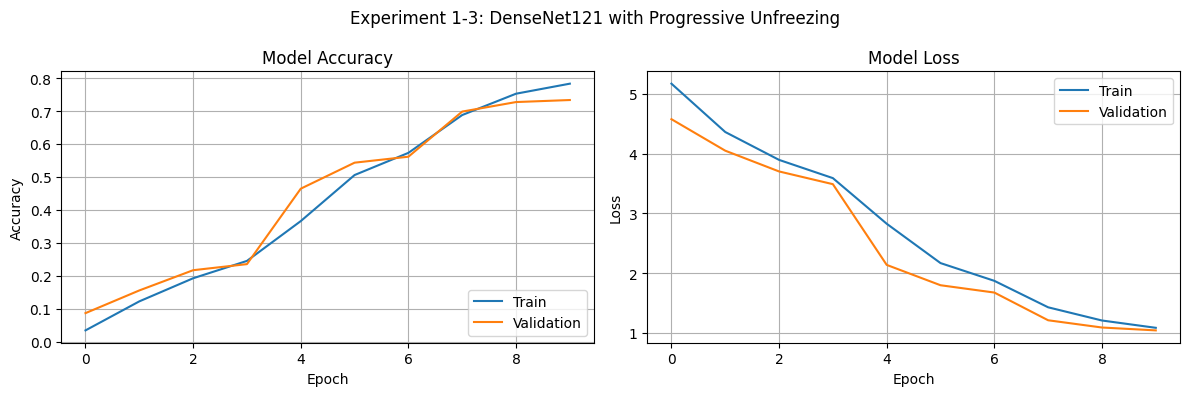


Evaluating model...


Evaluating: 100%|██████████| 84/84 [00:09<00:00,  8.68it/s]


Loss: 1.0800
F1 Score: 0.7170
Recall: 0.7169
Precision: 0.7543
Accuracy: 0.7169
Saving model to Google Drive: /content/drive/MyDrive/car_classification_models/densenet121_progressive.pth
Model saved to /content/drive/MyDrive/car_classification_models/densenet121_progressive.pth
time: 9min 20s (started: 2025-03-12 19:34:20 +00:00)


In [ ]:
def experiment1_3_densenet121_progressive(train_subset, val_subset, test_subset, batch_size=32, num_epochs=10, device=device):
    """
    Experiment 1-3: DenseNet121 with Progressive Unfreezing
    - Start with only the classifier, then gradually unfreeze blocks from top to bottom
    - Moderate augmentation (random crop, flip, rotation)
    - Progressive learning rate reduction as more layers are unfrozen
    """
    print("\n" + "="*70)
    print("EXPERIMENT 1-3: DenseNet121 with Progressive Unfreezing")
    print("="*70)
    print("This experiment uses DenseNet121 with moderate data augmentation")
    print("and progressive unfreezing: starting with the classifier only, then gradually")
    print("unfreezing more layers from top to bottom with decreasing learning rates.")

    # Define moderate augmentation transform
    moderate_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),  # Moderate rotation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply transform to dataset if needed
    if hasattr(train_subset, 'root'):
        # If train_subset is a dataset with a root directory
        train_root_dir = train_subset.root
        train_dataset_moderate = ImageFolder(root=train_root_dir, transform=moderate_transform)
        train_loader_moderate = DataLoader(train_dataset_moderate, batch_size=batch_size, shuffle=True, num_workers=4)
    else:
        # Fallback - use existing dataset
        print("Warning: Could not apply moderate transform, using dataset as is.")
        train_loader_moderate = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)

    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4)

    dataloaders_progressive = {
        'train': train_loader_moderate,
        'val': val_loader
    }

    # Get number of classes
    num_classes = len(train_dataset.classes)
    print(f"Number of classes: {num_classes}")

    # Setup model - DenseNet121 with feature extraction initially
    model = setup_model('densenet121', num_classes, feature_extract=True)

    # Print model architecture summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Initial trainable parameters: {trainable_params:,}")
    print(f"Percentage of trainable parameters: {trainable_params/total_params*100:.2f}%")

    # Divide epochs between stages (3 stages)
    epochs_per_stage = num_epochs // 3
    remaining_epochs = num_epochs % 3
    stage_epochs = [epochs_per_stage] * 3
    # Distribute remaining epochs
    for i in range(remaining_epochs):
        stage_epochs[i] += 1

    print(f"\nProgressive training schedule:")
    print(f"Stage 1: Training only classifier for {stage_epochs[0]} epochs")
    print(f"Stage 2: Adding last dense block for {stage_epochs[1]} epochs")
    print(f"Stage 3: Adding second-to-last dense block for {stage_epochs[2]} epochs")

    # Combined history
    combined_history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'time_per_epoch': []
    }

    # Keep track of best model
    best_model_wts = None
    best_acc = 0.0

    # STAGE 1: Train only the classifier
    print("\n=== STAGE 1: Training only classifier ===")
    criterion = nn.CrossEntropyLoss()
    # High learning rate for classifier only
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, history1 = train_model(model, dataloaders_progressive, criterion, optimizer,
                                scheduler, num_epochs=stage_epochs[0], device=device)

    # Update combined history
    for key in combined_history:
        combined_history[key].extend(history1[key])

    # Update best model if improved
    if history1['val_acc'] and max(history1['val_acc']) > best_acc:
        best_acc = max(history1['val_acc'])
        best_model_wts = copy.deepcopy(model.state_dict())

    # STAGE 2: Unfreeze last dense block
    if stage_epochs[1] > 0:
        print("\n=== STAGE 2: Unfreezing last dense block ===")
        # Unfreeze the last dense block (denseblock4)
        for name, child in model.features.named_children():
            if name == 'denseblock4':
                for param in child.parameters():
                    param.requires_grad = True

        # Print updated trainable parameters
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Updated trainable parameters: {trainable_params:,}")
        print(f"Percentage of trainable parameters: {trainable_params/total_params*100:.2f}%")

        # Medium learning rate for more parameters
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        model, history2 = train_model(model, dataloaders_progressive, criterion, optimizer,
                                    scheduler, num_epochs=stage_epochs[1], device=device)

        # Update combined history
        for key in combined_history:
            combined_history[key].extend(history2[key])

        # Update best model if improved
        if history2['val_acc'] and max(history2['val_acc']) > best_acc:
            best_acc = max(history2['val_acc'])
            best_model_wts = copy.deepcopy(model.state_dict())

    # STAGE 3: Unfreeze second-to-last dense block
    if stage_epochs[2] > 0:
        print("\n=== STAGE 3: Unfreezing second-to-last dense block ===")
        # Unfreeze the second-to-last dense block (denseblock3)
        for name, child in model.features.named_children():
            if name == 'denseblock3':
                for param in child.parameters():
                    param.requires_grad = True

        # Print updated trainable parameters
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Updated trainable parameters: {trainable_params:,}")
        print(f"Percentage of trainable parameters: {trainable_params/total_params*100:.2f}%")

        # Lower learning rate for even more parameters
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        model, history3 = train_model(model, dataloaders_progressive, criterion, optimizer,
                                    scheduler, num_epochs=stage_epochs[2], device=device)

        # Update combined history
        for key in combined_history:
            combined_history[key].extend(history3[key])

        # Update best model if improved
        if history3['val_acc'] and max(history3['val_acc']) > best_acc:
            best_acc = max(history3['val_acc'])
            best_model_wts = copy.deepcopy(model.state_dict())

    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
        print(f"Loaded best model with validation accuracy: {best_acc:.4f}")

    # Plot training history
    plot_training_history(combined_history, title="Experiment 1-3: DenseNet121 with Progressive Unfreezing")

    # Evaluate model
    print("\nEvaluating model...")
    metrics, labels, preds = evaluate_model(model, test_loader, criterion, device=device)

    print(f"Loss: {metrics['loss']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")

    # Try to save model to Google Drive first
    try:
        drive_dir = "/content/drive/MyDrive/car_classification_models"
        os.makedirs(drive_dir, exist_ok=True)
        save_path = f"{drive_dir}/densenet121_progressive.pth"
        print(f"Saving model to Google Drive: {save_path}")
    except (ImportError, ValueError):
        # If not running in Colab or Drive not mounted
        save_path = "densenet121_progressive.pth"
        print(f"Saving model locally: {save_path}")

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics,
        'history': combined_history,
        'num_classes': num_classes,
        'epoch': num_epochs
    }, save_path)
    print(f"Model saved to {save_path}")

    return model, metrics, combined_history

# Run Experiment 1-3
model_1_3, metrics_1_3, history_1_3 = experiment1_3_densenet121_progressive(
    train_subset, val_subset, new_test_subset, num_epochs=10)

# Add to experiment tracker
experiment_tracker.add_experiment("DenseNet121_Progressive", model_1_3, metrics_1_3, history_1_3)


### Comparing Experiments and Saving Results
##### This block compares the results from all transfer learning experiments by plotting metrics and histories. It also saves the best-performing model and all experiment models to Google Drive or a local directory, and provides a summary of the saved files.


COMPARING ALL TRANSFER LEARNING EXPERIMENTS
Google Drive is already mounted
✅ Directory created or already exists: /content/drive/MyDrive/car_classification_models
✅ Write access verified

Metrics Comparison:
                                loss  accuracy        f1  precision    recall
ResNet50_FeatureExtraction  2.372367  0.423704  0.419584   0.429137  0.423704
ResNet50_FineTuning         0.901199  0.737784  0.736278   0.781804  0.737784
DenseNet121_Progressive     1.080043  0.716897  0.717020   0.754308  0.716897


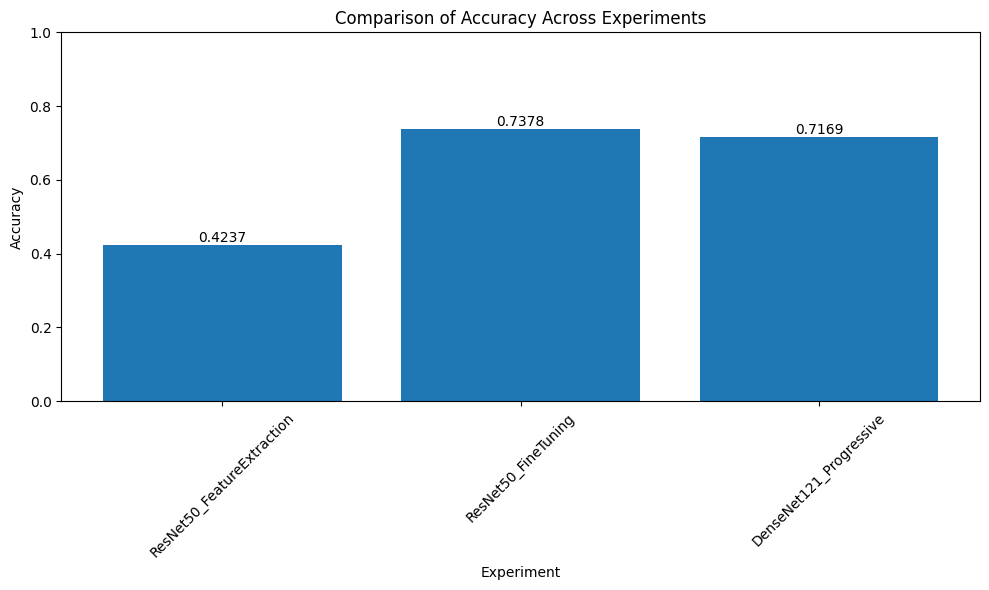

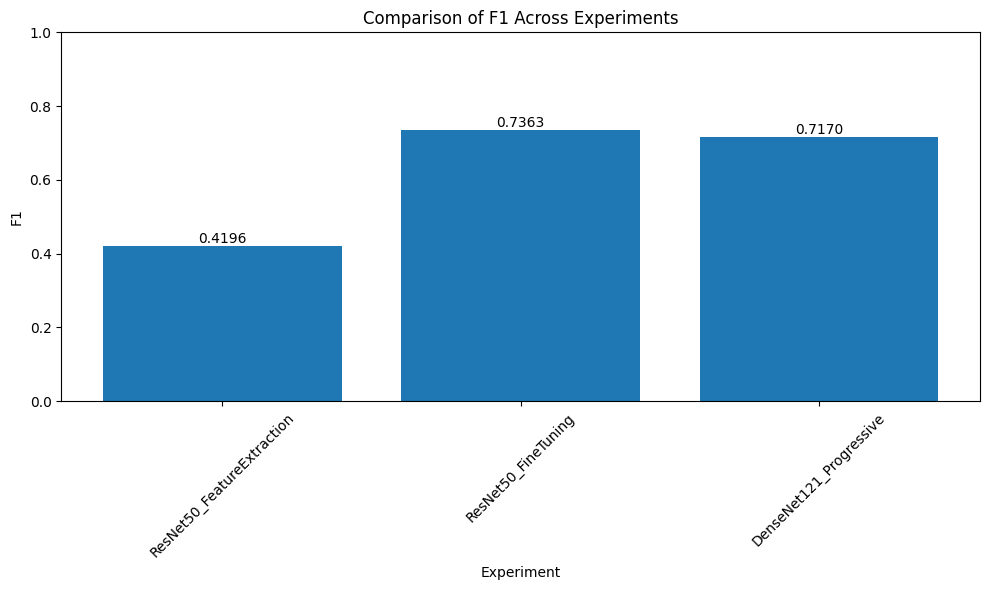

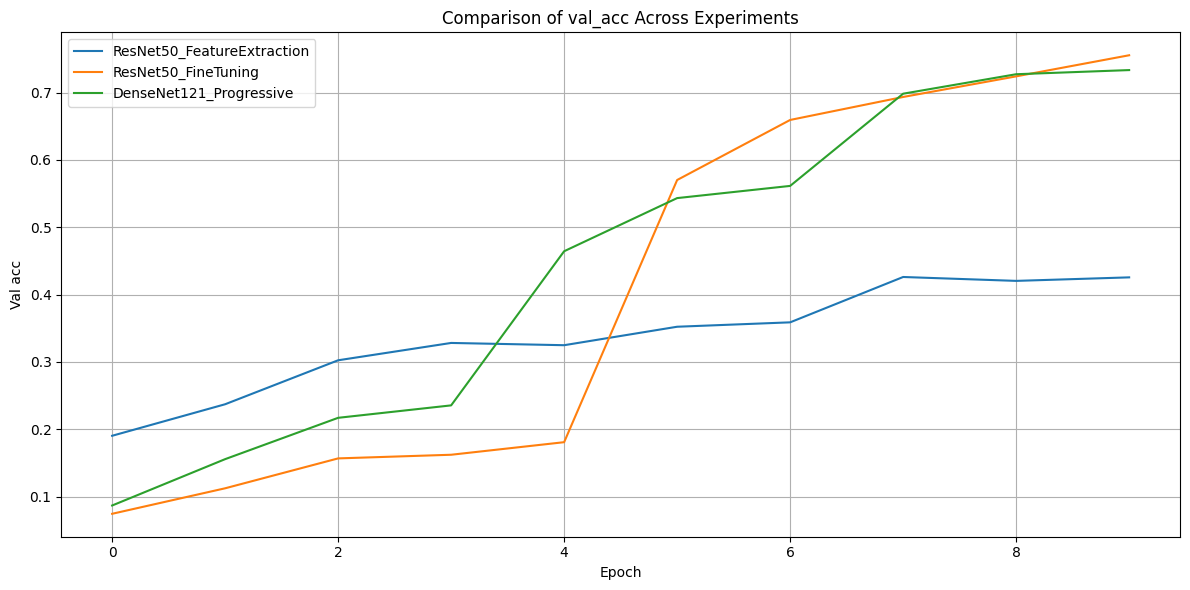

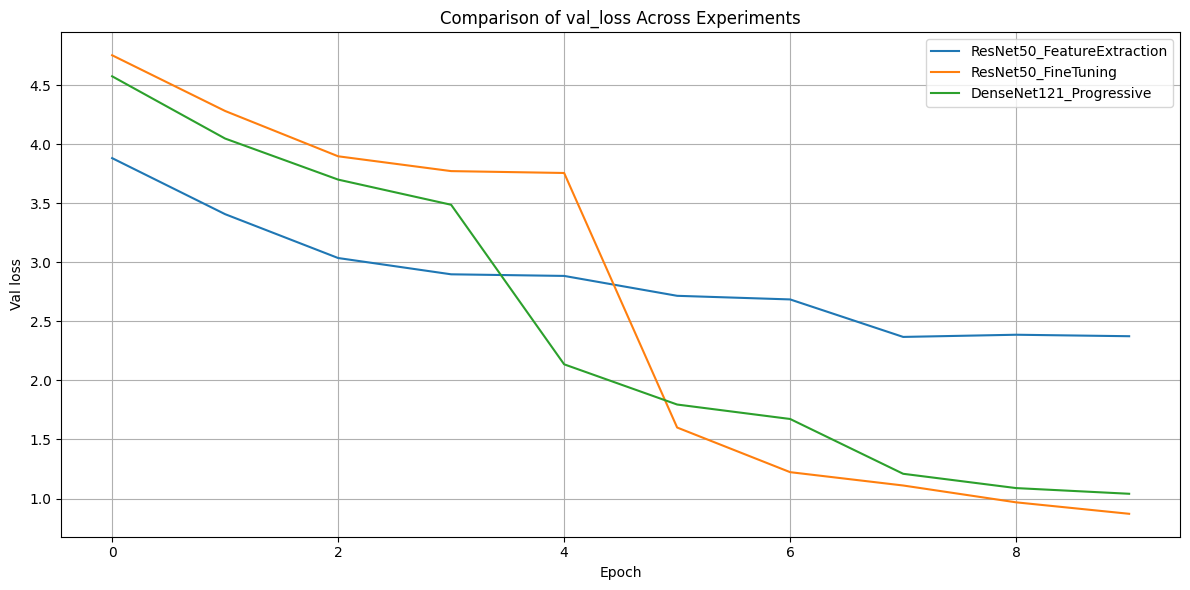

Best experiment based on accuracy: ResNet50_FineTuning with value 0.7378
Best model (ResNet50_FineTuning) saved to /content/drive/MyDrive/car_classification_models/best_transfer_learning_model.pth
✅ Best model saved to: /content/drive/MyDrive/car_classification_models/best_transfer_learning_model.pth
✅ Saved model: /content/drive/MyDrive/car_classification_models/ResNet50_FeatureExtraction.pth
✅ Saved model: /content/drive/MyDrive/car_classification_models/ResNet50_FineTuning.pth
✅ Saved model: /content/drive/MyDrive/car_classification_models/DenseNet121_Progressive.pth
✅ Metrics saved to: /content/drive/MyDrive/car_classification_models/metrics_comparison.csv

Experiment complete! Best model: ResNet50_FineTuning
All models saved in: /content/drive/MyDrive/car_classification_models

Saved files (7):
  - best_transfer_learning_model.pth (91.52 MB)
  - ResNet50_FeatureExtraction.pth (91.52 MB)
  - ResNet50_FineTuning.pth (91.51 MB)
  - densenet121_progressive.pth (67.74 MB)
  - metrics_c

In [ ]:
# Compare all experiments and find the best model
print("\n" + "="*70)
print("COMPARING ALL TRANSFER LEARNING EXPERIMENTS")
print("="*70)

# Mount Google Drive if not already mounted
try:
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
        print("✅ Google Drive mounted successfully")
    else:
        print("Google Drive is already mounted")
except ImportError:
    print("Not running in Colab, skipping Google Drive mount")

# Create a directory for models
save_dir = "/content/drive/MyDrive/car_classification_models"
os.makedirs(save_dir, exist_ok=True)
print(f"✅ Directory created or already exists: {save_dir}")

# Verify write access
test_path = os.path.join(save_dir, "test_write.txt")
try:
    with open(test_path, "w") as f:
        f.write("Test file to verify write access")
    print("✅ Write access verified")
except Exception as e:
    print(f"⚠️ Write access failed: {e}")

# Compare metrics
try:
    metrics_comparison = experiment_tracker.compare_metrics()
    print("\nMetrics Comparison:")
    print(metrics_comparison)
except Exception as e:
    print(f"⚠️ Error comparing metrics: {e}")
    metrics_comparison = None

# Plot metrics
try:
    experiment_tracker.plot_metric_comparison("accuracy")
    experiment_tracker.plot_metric_comparison("f1")
except Exception as e:
    print(f"⚠️ Error plotting metrics: {e}")

# Plot histories
try:
    experiment_tracker.plot_history_comparison("val_acc")
    experiment_tracker.plot_history_comparison("val_loss")
except Exception as e:
    print(f"⚠️ Error plotting histories: {e}")

# Save best model
best_model_path = os.path.join(save_dir, "best_transfer_learning_model.pth")
try:
    best_model_name = experiment_tracker.save_best_model("accuracy", best_model_path)
    print(f"✅ Best model saved to: {best_model_path}")
except Exception as e:
    print(f"⚠️ Error saving best model: {e}")

# Save all models
for exp_name, exp_data in experiment_tracker.experiments.items():
    model_path = os.path.join(save_dir, f"{exp_name}.pth")
    try:
        torch.save(exp_data["model"].state_dict(), model_path)
        print(f"✅ Saved model: {model_path}")
    except Exception as e:
        print(f"⚠️ Error saving {exp_name}: {e}")

# Save metrics comparison CSV
if metrics_comparison is not None:
    csv_path = os.path.join(save_dir, "metrics_comparison.csv")
    try:
        metrics_comparison.to_csv(csv_path)
        print(f"✅ Metrics saved to: {csv_path}")
    except Exception as e:
        print(f"⚠️ Error saving metrics CSV: {e}")

# Final message
print(f"\nExperiment complete! Best model: {best_model_name}")
print(f"All models saved in: {save_dir}")

# List saved files
files = os.listdir(save_dir)
if files:
    print(f"\nSaved files ({len(files)}):")
    for file in files:
        size_mb = os.path.getsize(os.path.join(save_dir, file)) / (1024 * 1024)
        print(f"  - {file} ({size_mb:.2f} MB)")
else:
    print("\n⚠️ No files found in save directory.")


### Best Model Testing and Prediction

##### This block handles the testing and prediction of car models using the best model and KNN classifier (if available). It loads the pre-trained model, sets up the feature extractor, and makes predictions on uploaded images.


*   **Model and KNN Classifier Loading** - The pre-trained model and KNN classifier are loaded from Google Drive. The model architecture is detected and set up.
*   **Feature Extractor Creation** - The feature extractor is created by removing the final layer for feature extraction.
*   **Prediction Functions** - Predictions are made using either direct classification or the KNN classifier, with confidence scores displayed.
*   **Batch Image Processing** - Multiple images can be uploaded, classified, and displayed with the prediction results.

Google Drive already mounted or not in Colab
Using device: cuda:0
Checking for model file at: /content/drive/MyDrive/car_classification_models/best_transfer_learning_model.pth
Model file exists: True
Checking for KNN classifier at: /content/drive/MyDrive/car_classification_models/knn_classifier.pkl
KNN classifier exists: False

Loading best model...
Detected model architecture: resnet50


<ipython-input-17-52029e22450a>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path, map_location='cpu')
<ipython-input-17-52029e22450a

✅ Model weights loaded successfully from best_transfer_learning_model.pth
✅ Feature extractor created
KNN classifier not found. Only direct model predictions will be available.

Loaded 196 class names from train dataset

CAR IMAGE CLASSIFICATION USING BEST MODEL
Using direct classification

Upload images of cars to classify them (you can select multiple files):
📤 Upload multiple car images for classification:


Saving class_1.jfif to class_1.jfif
Saving class_2.jfif to class_2.jfif
Saving class_6.jfif to class_6.jfif
Saving class_9.jfif to class_9.jfif
Saving class_12.jfif to class_12.jfif
Saving class_15.jfif to class_15.jfif
Saving class_30.jfif to class_30.jfif
Saving class_42.jfif to class_42.jfif
Saving class_61.jfif to class_61.jfif
Saving class_185.jfif to class_185.jfif

🔄 Processing 10 image(s)...


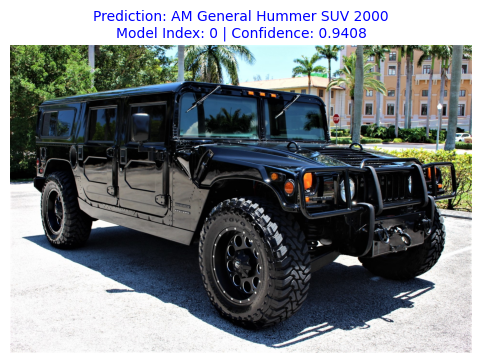

📄 File: class_1.jfif
🚗 Predicted car model (Direct): AM General Hummer SUV 2000
🔢 Model class index: 0
✓ Confidence: 0.9408
✅ CORRECT: Filename class 1 matches model index 0
--------------------------------------------------


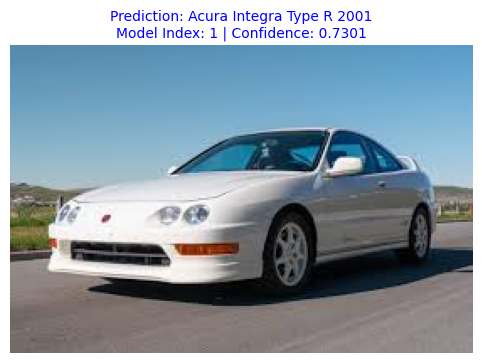

📄 File: class_2.jfif
🚗 Predicted car model (Direct): Acura Integra Type R 2001
🔢 Model class index: 1
✓ Confidence: 0.7301
✅ CORRECT: Filename class 2 matches model index 1
--------------------------------------------------


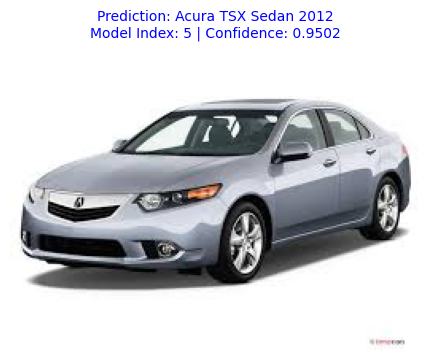

📄 File: class_6.jfif
🚗 Predicted car model (Direct): Acura TSX Sedan 2012
🔢 Model class index: 5
✓ Confidence: 0.9502
✅ CORRECT: Filename class 6 matches model index 5
--------------------------------------------------


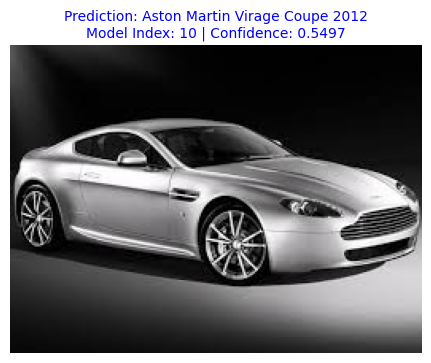

📄 File: class_9.jfif
🚗 Predicted car model (Direct): Aston Martin Virage Coupe 2012
🔢 Model class index: 10
✓ Confidence: 0.5497
❌ INCORRECT: Filename class 9 differs from prediction (model index 10)
--------------------------------------------------


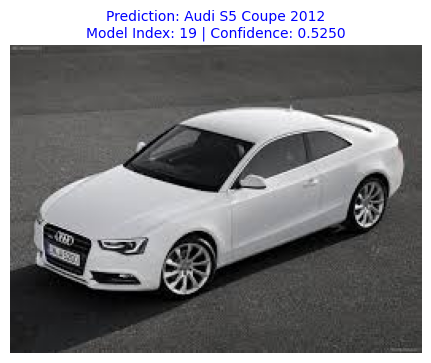

📄 File: class_12.jfif
🚗 Predicted car model (Direct): Audi S5 Coupe 2012
🔢 Model class index: 19
✓ Confidence: 0.5250
❌ INCORRECT: Filename class 12 differs from prediction (model index 19)
--------------------------------------------------


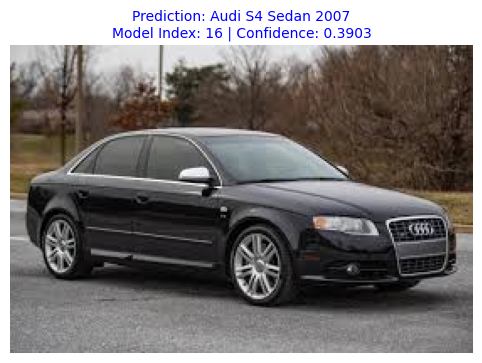

📄 File: class_15.jfif
🚗 Predicted car model (Direct): Audi S4 Sedan 2007
🔢 Model class index: 16
✓ Confidence: 0.3903
❌ INCORRECT: Filename class 15 differs from prediction (model index 16)
--------------------------------------------------


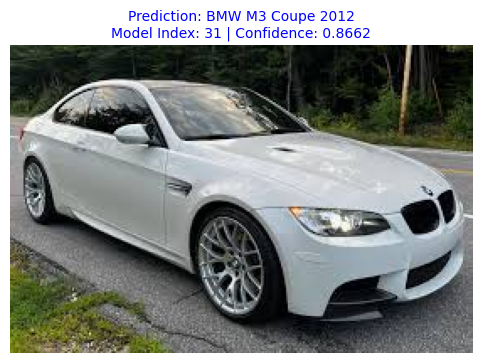

📄 File: class_30.jfif
🚗 Predicted car model (Direct): BMW M3 Coupe 2012
🔢 Model class index: 31
✓ Confidence: 0.8662
❌ INCORRECT: Filename class 30 differs from prediction (model index 31)
--------------------------------------------------


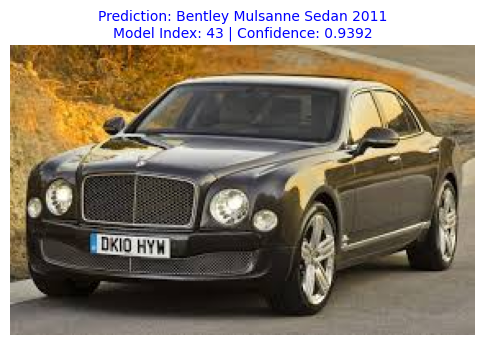

📄 File: class_42.jfif
🚗 Predicted car model (Direct): Bentley Mulsanne Sedan 2011
🔢 Model class index: 43
✓ Confidence: 0.9392
❌ INCORRECT: Filename class 42 differs from prediction (model index 43)
--------------------------------------------------


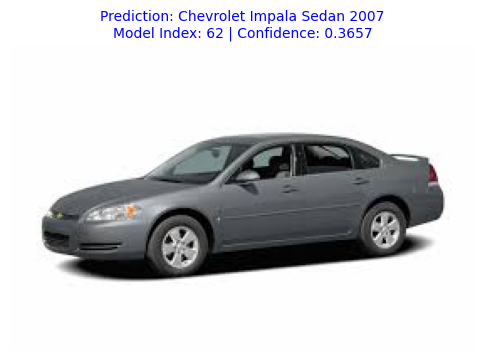

📄 File: class_61.jfif
🚗 Predicted car model (Direct): Chevrolet Impala Sedan 2007
🔢 Model class index: 62
✓ Confidence: 0.3657
❌ INCORRECT: Filename class 61 differs from prediction (model index 62)
--------------------------------------------------


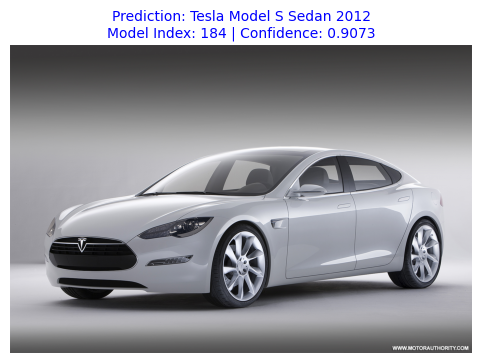

📄 File: class_185.jfif
🚗 Predicted car model (Direct): Tesla Model S Sedan 2012
🔢 Model class index: 184
✓ Confidence: 0.9073
✅ CORRECT: Filename class 185 matches model index 184
--------------------------------------------------

✅ 4 CORRECT predictions
❌ 6 INCORRECT predictions

✅ All images processed.
time: 1min 45s (started: 2025-03-12 19:43:42 +00:00)


In [ ]:
from google.colab import files

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully")
except:
    print("Google Drive already mounted or not in Colab")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to model files
model_path = "/content/drive/MyDrive/car_classification_models/best_transfer_learning_model.pth"
knn_model_path = "/content/drive/MyDrive/car_classification_models/knn_classifier.pkl"

# Check file existence
print(f"Checking for model file at: {model_path}")
model_exists = os.path.exists(model_path)
print(f"Model file exists: {model_exists}")

print(f"Checking for KNN classifier at: {knn_model_path}")
knn_exists = os.path.exists(knn_model_path)
print(f"KNN classifier exists: {knn_exists}")

# Function to detect model architecture from state dict
def detect_model_architecture(state_dict_path):
    try:
        state_dict = torch.load(state_dict_path, map_location='cpu')

        # Check for DenseNet specific keys
        if any('features.denseblock' in key for key in state_dict.keys()):
            return "densenet121"
        # Check for ResNet specific keys
        elif any('layer1' in key for key in state_dict.keys()):
            return "resnet50"
        else:
            print("Could not determine model architecture, defaulting to ResNet50")
            return "resnet50"
    except Exception as e:
        print(f"Error detecting model architecture: {e}")
        return "resnet50"  # Default to ResNet50

# Function to create a feature extractor
def create_feature_extractor(model, model_type):
    """Create a feature extractor by removing the final layer of a model."""
    feature_extractor = copy.deepcopy(model)

    if model_type == "resnet50":
        feature_extractor.fc = nn.Identity()
    elif model_type == "densenet121":
        feature_extractor.classifier = nn.Identity()
    else:
        print(f"Unknown model type: {model_type}. Using as ResNet.")
        feature_extractor.fc = nn.Identity()

    return feature_extractor

# Load the model
print("\nLoading best model...")
try:
    # Detect model architecture
    model_type = "resnet50"  # Default
    if model_exists:
        model_type = detect_model_architecture(model_path)
        print(f"Detected model architecture: {model_type}")

    # Create appropriate model based on detected type
    if model_type == "densenet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 196)  # 196 classes for Cars dataset
    else:  # Default to resnet50
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 196)  # 196 classes for Cars dataset

    # Load weights if available
    if model_exists:
        # Load the state dict
        checkpoint = torch.load(model_path, map_location=device)

        # Handle different saved formats
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)

        print(f"✅ Model weights loaded successfully from {os.path.basename(model_path)}")
    else:
        print("⚠️ Using pre-trained ImageNet weights (custom model not found)")

    model = model.to(device)
    model.eval()

    # Create feature extractor
    feature_extractor = create_feature_extractor(model, model_type)
    feature_extractor = feature_extractor.to(device)
    print("✅ Feature extractor created")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, 196)
    model = model.to(device)
    model.eval()
    feature_extractor = create_feature_extractor(model, "resnet50")
    feature_extractor = feature_extractor.to(device)
    print("Using default ImageNet model")

# Load KNN classifier if it exists
knn_classifier = None
if knn_exists:
    try:
        print("\nLoading KNN classifier...")
        with open(knn_model_path, 'rb') as f:
            knn_classifier = pickle.load(f)
        print(f"✅ KNN classifier loaded with k={knn_classifier.n_neighbors}")
    except Exception as e:
        print(f"❌ Error loading KNN classifier: {e}")
        knn_classifier = None
else:
    print("KNN classifier not found. Only direct model predictions will be available.")

# Image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Try to load class names from train dataset if available
try:
    from torchvision.datasets import ImageFolder
    train_dir = "/content/dataset/cars_train/cars_train"
    if os.path.exists(train_dir):
        train_dataset = ImageFolder(root=train_dir)
        class_names = train_dataset.classes
        print(f"\nLoaded {len(class_names)} class names from train dataset")
    else:
        # Default class names for Stanford Cars (truncated)
        class_names = [f"Class {i}" for i in range(196)]
        print("\nUsing default class indices as names")
except Exception as e:
    print(f"\nCould not load class names: {e}")
    # Default class names for Stanford Cars (truncated)
    class_names = [f"Class {i}" for i in range(196)]
    print("Using default class indices as names")

# Function to extract features from an image
def extract_image_features(img, feature_extractor, device):
    """Extract features for a single image using the feature extractor."""
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = feature_extractor(img_tensor)

    return features.cpu().numpy().flatten()

# Function to predict using direct classification
def predict_direct(img, model, device):
    """Predict class directly using the model."""
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        top_prob, top_idx = torch.max(probs, 1)

    return {
        'class': top_idx.item(),
        'confidence': top_prob.item()
    }

# Function to predict using KNN on features
def predict_knn(img, feature_extractor, knn_classifier, device):
    """Predict class using KNN on extracted features."""
    features = extract_image_features(img, feature_extractor, device)

    # Make prediction
    pred_class = knn_classifier.predict([features])[0]

    # Get probabilities if KNN supports it
    if hasattr(knn_classifier, 'predict_proba'):
        probs = knn_classifier.predict_proba([features])[0]
        max_prob_idx = np.argmax(probs)
        confidence = probs[max_prob_idx]
    else:
        # If not using a probabilistic model, just use 1.0 as confidence
        confidence = 1.0

    return {
        'class': pred_class,
        'confidence': confidence
    }

# Function to check if the predicted class matches the filename class
def check_class_match(img_file, class_idx):
    """
    Function to extract class number from filename and compare with predicted class index.
    """
    try:
        filename = img_file.name.lower()
        match = re.search(r'class[_\s]*(\d+)', filename)
        if match:
            file_class = int(match.group(1))
            expected_model_idx = file_class - 1

            if expected_model_idx == class_idx:
                print(f"✅ CORRECT: Filename class {file_class} matches model index {class_idx}")
                return "CORRECT"
            else:
                print(f"❌ INCORRECT: Filename class {file_class} differs from prediction (model index {class_idx})")
                return "INCORRECT"
    except Exception as e:
        print(f"Error extracting class from filename: {e}")
        return "INCORRECT"

# Function to predict car model from uploaded image
def predict_car_model(img_file):
    img = Image.open(img_file).convert('RGB')

    # Predict using KNN or Direct model
    prediction = predict_knn(img, feature_extractor, knn_classifier, device) if knn_classifier else predict_direct(img, model, device)
    model_type = "KNN" if knn_classifier else "Direct"

    # Display the image with its prediction
    display_image(img, prediction, model_type, img_file.name)

    # Check if prediction matches the filename class
    result = check_class_match(img_file, prediction['class'])
    print("-" * 50)

    return result

# Function to display the image and its prediction
def display_image(img, prediction, model_type, img_name):
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.axis('off')

    class_idx = prediction['class']
    class_name = class_names[class_idx] if class_idx < len(class_names) else f"Unknown Class {class_idx}"

    plt.title(f"Prediction: {class_name}\nModel Index: {class_idx} | Confidence: {prediction['confidence']:.4f}", fontsize=10, color='blue')
    plt.show()

    print(f"📄 File: {img_name}")  # Display the file name
    print(f"🚗 Predicted car model ({model_type}): {class_name}")
    print(f"🔢 Model class index: {class_idx}")
    print(f"✓ Confidence: {prediction['confidence']:.4f}")

# Function to handle multiple image uploads
def upload_and_predict_multiple():
    print("📤 Upload multiple car images for classification:")

    uploaded = files.upload()
    if not uploaded:
        print("No files uploaded.")
        return

    print(f"\n🔄 Processing {len(uploaded)} image(s)...")

    correct_count = 0
    incorrect_count = 0

    for filename, content in uploaded.items():
        img_file = io.BytesIO(content)
        img_file.name = filename
        result = predict_car_model(img_file)  # Get the result of the prediction (CORRECT or INCORRECT)

        if result == "CORRECT":
            correct_count += 1
        else:
            incorrect_count += 1

    print(f"\n✅ {correct_count} CORRECT predictions")
    print(f"❌ {incorrect_count} INCORRECT predictions")
    print("\n✅ All images processed.")


# Start the upload process
print("\n" + "="*50)
print("CAR IMAGE CLASSIFICATION USING BEST MODEL")
print("="*50)
if knn_classifier:
    print(f"Using model with KNN classifier (k={knn_classifier.n_neighbors})")
else:
    print("Using direct classification")

print("\nUpload images of cars to classify them (you can select multiple files):")
upload_and_predict_multiple()

